Von [Pascal Schlaak](mailto:pascal.schlaak@studmail.htw-aalen.de), [Tim Weise](mailto:tim.weise@studmail.htw-aalen.de) - Natural Language Processing (SoSe 20)

# Verarbeitung aller Dateneinträge

Nachdem wir nun anhand der Validierung eines einzelnen Dateneintrages eine geeignete Vorverarbeitung der Zusammenfassung erstellt haben, können wir diese nun auf alle Dateneinträge anwenden. Es soll ebenfalls untersucht werden, welche Auswirkungen die Verarbeitung der Daten auf dessen Varianz haben.

## Module importieren

Zur Verarbeitung der Datenbasis werden folgende Module benötigt und müssen zuerst importiert werden.

In [1]:
import spacy
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

## Daten einlesen

In [2]:
# Pfad zu JSON-Datei
PATH_TO_DATA = '../data/movies.json'
# Einlesen der JSON-Datei in DataFrame
data = pd.read_json(PATH_TO_DATA)

Durch die `len()` Methode können wir uns einen Überblick über die Größe des Datensatz verschaffen. Dies ist wichtig, um zu validieren, ob alle Daten gecrawlt wurden.

In [3]:
number_movies = len(data)
number_movies

250

Diese Anzahl bietet uns eine solide Datenbasis für kommende Verarbeitungsschritte. Neben der Anzahl an Filmeinträgen ist eine höhere Anzahl von Wörtern pro Zusammenfassung ebenfalls von Vorteil, da man somit mehr Informationen über den Filminhalt hat. Im Folgenden wird die gesamte Anzahl an Wörtern pro Zusammenfassung mit der effektiv für die Transformation genutzten Anzahl an Wörtern verglichen. Dieser Vergleich bietet uns Einblicke in den Verlust von Wörtern, wie beispielsweise Stoppwörtern, welche kein nützliches Wissen für die Analyse des Filminhaltes darstellen.

## Datenbereinigung

In einer ersten Iteration der Analyse aller Dateneinträge hat sich herausgestellt, dass es mehrere Einträge gibt, welche nur über eine Anzahl von 40 Wörter in der Zusammenfassung verfügen.

In [4]:
data[data.title == 'Modern Times']

,title,date,rank,synopsis
36,Modern Times,1936,52,\n It looks like we don't have ...


Nach einer gründlichen Sichtung der Daten hat sich herausgestellt, dass es sich hierbei um einen Platzhalter handelt, wenn es noch keine Zusammenfassung für Einträge gibt.

In [5]:
data.iloc[36]['synopsis']

'\n                It looks like we don\'t have a Synopsis for this title yet. Be the first to contribute! Just click the "Edit page" button at the bottom of the page or learn more in the Synopsis submission guide.\n            '

Wir bereinigen deswegen unseren Datensatz dahingehend, dass wir alle Einträge, welche über diesen Platzhalter in der Zusammenfassung verfügen, entfernen. Dies hat vor allem den Grund, dass wir aus diesem Platzhalter keine Informationen über den Inhalt des Films erreichen können. Die dabei entfernten Titel werden im Folgenden ausgegeben.

In [6]:
disclaimer = 'It looks like we don\'t have a Synopsis for this title yet.'
for index, movie in data.iterrows():
    if disclaimer in movie['synopsis']:
        print(movie['title'])
        data = data.drop(index)

Modern Times
Mein Vater und mein Sohn
The Bandit
High and Low
Capernaum
Come and See
Wild Tales
The Invisible Guest
La Haine
Nausicaä of the Valley of the Wind
The 400 Blows
The Circus
The Kid


Wir erhalten somit einen Datensatz mit 237 Einträgen.

In [7]:
len(data)

237

## Analyse aller Dateneinträge

Im Folgenden untersuchen wir die Größe der Zusammenfassungen basieren auf dessen Wortanzahlen. Da wir im nächsten Kapitel den k-Means-Clustering-Algorithmus anwenden möchten, ist es sinnvoll die Varianz der Daten zu reduzieren, damit eine zufriedenstellende Aufteilung der Dateneinträge in Genres möglich ist. Wir iterieren hierfür über unsere gesamte nicht vorverarbeitete Datenbasis und zählen die Anzahl der Wörter (ohne Satzzeichen) unserer Zusammenfassungen. Diese speichern wir wiederum in einem DataFrame, welches uns weitere arithmetische Operationen erleichtert. Man beachte, dass es sich bei den hier resultierenden Token ebenfalls um Stoppwörter und Eigennamen handelt. Wir vorverarbeiten die Daten erst im nächsten Schritt um eine Vergleichwert zu haben.

In [8]:
counters = []
# Laden des Sprach-Supports für spätere Analysen wie POS-Tagging
nlp = spacy.load("en_core_web_sm")
# Iteriere über jeden Film in Daten
for index, movie in data.iterrows():
    # Berechnen der Anzahl an Wörtern ohne Satzzeichen
    counters.append({'title': movie['title'], 'token': len([token.text for token in nlp(movie['synopsis']) if not token.is_punct])})
total_number_words = pd.DataFrame(counters)

In [9]:
total_number_words

,title,token
0,The Shawshank Redemption,3741
1,The Dark Knight,6849
2,The Godfather,3237
3,The Godfather: Part II,2605
4,Pulp Fiction,1788
...,...,...
232,The Wolf of Wall Street,4150
233,Green Book,1815
234,Metropolis,2019
235,"Three Billboards Outside Ebbing, Missouri",1639


Wir berechnen die durchschnittliche Anzahl an Wörtern unsere Daten und identifizieren Minima und Maxima. Wir nutzen zur Identifizierung der Minima und Maxima zuerst Pandas `argmin()` und `argmax()` Methode, welche uns die Indices des ersten Dateneintrages mit der minimalen/maximalen Anzahl, in diesem Fall Token, zurückgeben. Pandas `iloc[]` erlaubt es uns danach den Inhalt des Eintrages an einem bestimmten Index zurückzugeben. Wir entpacken dessen Ergebnis in zwei Variablen.

In [10]:
# Durchschnittliche Anzahl an Wörtern berechnen
total_average_words = round(sum(total_number_words['token']) / number_movies)
print('Durschnitt:\t{} Wörter'.format(total_average_words))
# Minimale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_min_total, value_min_total = total_number_words.iloc[total_number_words['token'].argmin()]
print('Minimal:\t{} Wörter\tbei\t{}'.format(value_min_total, title_min_total))
# Maximale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_max_total, value_max_total = title_min_total, value_min_total = total_number_words.iloc[total_number_words['token'].argmax()]
print('Maximal:\t{} Wörter\tbei\t{}'.format(value_max_total, title_max_total))

Durschnitt:	2080 Wörter
Minimal:	107 Wörter	bei	Neon Genesis Evangelion: The End of Evangelion
Maximal:	11658 Wörter	bei	The Seventh Seal


Wie zu erkennen, unterscheiden sich die Extremwerte sehr.

Wir nutzen ebenfalls die Standardabweichung unserer Wortanzahlen als Metrik für die Varianz des Datensatzes. Hierfür verwenden wir `Numpy`s `std()` Methode.

In [11]:
np.std(list(total_number_words['token']))

1792.5923023234643

## Analyse der reduzierten Dateneinträge

Zur Analyse der vorverarbeitenden Dateneinträge verfahren wir analog wie zuvor, entfernen nur ebenso alle Stoppwörter, Eigennamen und Verben. Wir bilden ebenfalls die Grundform aller Wörter.

In [12]:
counters = []
# Iteriere über jeden Film in Daten
for index, movie in data.iterrows():
    # Berechnen der Anzahl an Wörtern
    counters.append({'title': movie['title'], 'token': len([token.lemma_ for token in nlp(movie['synopsis']) if not token.ent_type_ and not token.is_punct and not token.is_stop and token.pos_ != 'VERB'])})
reduced_number_words = pd.DataFrame(counters)

In [13]:
reduced_number_words

,title,token
0,The Shawshank Redemption,935
1,The Dark Knight,1417
2,The Godfather,766
3,The Godfather: Part II,541
4,Pulp Fiction,433
...,...,...
232,The Wolf of Wall Street,925
233,Green Book,399
234,Metropolis,521
235,"Three Billboards Outside Ebbing, Missouri",364


In [14]:
# Durchschnittliche Anzahl an Wörtern berechnen
reduced_average_words = round(sum(reduced_number_words['token']) / number_movies)
print('Durschnitt:\t{} Wörter'.format(reduced_average_words))
# Minimale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_min_reduced, value_min_reduced = reduced_number_words.iloc[reduced_number_words['token'].argmin()]
print('Minimal:\t{} Wörter\tbei\t{}'.format(value_min_reduced, title_min_reduced))
# Maximale Anzahl an Wörter finden und dessen Filmnamen ausgeben
title_max_reduced, value_max_reduced = reduced_number_words.iloc[reduced_number_words['token'].argmax()]
print('Maximal:\t{} Wörter\tbei\t{}'.format(value_max_reduced, title_max_reduced))

Durschnitt:	502 Wörter
Minimal:	22 Wörter	bei	Neon Genesis Evangelion: The End of Evangelion
Maximal:	3238 Wörter	bei	The Seventh Seal


Es ist zu erkennen, dass wir die Varianz der Daten deutlich reduzieren konnten. Das BoW von *Neon Genesis Evangelion: The End of Evangelion* besteht nun lediglich aus 22 Wörtern. Wir müssen weiter untersuchen, ob eine zufriedenstellende Einteilung möglich ist. Andernfalls müssten wir diesen Film aus unserem Datensatz entfernen oder unsere Vorverarbeitung anpassen. 

Vergleichen wir nun die durchschnittliche Anzahl der unvorverarbeiteten Wortanzahlen mit den Wortanzahlen der vorverarbeiteten Zusammenfassungen, so konnten wir unseren BoW um rund 76 % reduzieren. Die Folge sind weniger Daten, die wir verarbeiten müssen, dennoch wichtige Informationen der Handlungen beinhalten.

In [15]:
print('~{} %'.format(100 - round((reduced_average_words / total_average_words) * 100, 0)))

~76.0 %


Eine logische Folgerung der Reduzierung unserer Daten (um Stoppwörter, Eigennamen, Verben), ist die Verringerung der Varianz der Token. Analog zu vorher können wir auch hier die Varianz der Daten mithilfe der Standardabweichung berechnen.

In [16]:
np.std(list(reduced_number_words['token']))

436.53325424244485

## Worthäufigkeit der gesamten reduzierten Daten

Für ein besseres Verständnis unserer späteren Clusteranalyse berechnen wir die Worthäufigkeit unserer gesamten reduzierten Daten. Dies soll es uns später erleichtern Trends in den Clustern zu erkennen. Wir verfahren analog zur Verarbeitung und Analyse eines einzelnen Dateneintrages und visualisieren die 20 am häufigsten genutzten Wörter alle vorverarbeitenden Dateneinträge.

In [17]:
total_words_without_ents, total_entities = [], []
for index, movie in data.iterrows():
    # Generierung einer Liste von allen lemmatisierten Tokens
    total_words_without_ents.extend([token.lemma_ for token in nlp(movie['synopsis']) if not token.ent_type_ and not token.is_stop and not token.is_punct and token.pos_ != 'VERB'])
    # Generierung einer Liste aller Eigennamen
    total_entities.extend([token.text for token in nlp(movie['synopsis']).ents])

In [18]:
# Häufigesten 30 Wörter identifizieren
common_words = dict(Counter(total_words_without_ents).most_common(20))

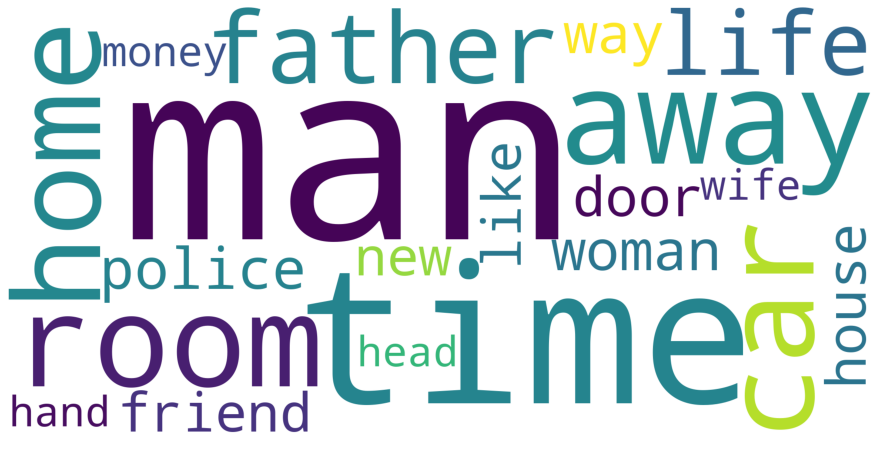

In [19]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

Es lässt sich erkennen, dass es sich generell in den Handlungen der Filmen vermehrt um männliche Figuren und interessanterweise auch des Öfteren um Polizei dreht. Dies sind Informationen, die wir beim Clustering unsere Daten beachten sollten. Es könnte beispielsweise sein, dass Polizei eine wichtige Rolle in mehreren Clustern spielt.

## Worthäufigkeit der Eigennamen

Nachdem nun generelle Informationen zu den Filminhalten erstellt wurden, können ebenso auch Eigennamen verarbeitet werden. Dies könnte interessant sein, um gängige Rollennamen, Spielorte, Jahr oder Schauspieler identifizieren zu können. In einer Optimierung des Projektes könnte beispielsweise versucht werden, die Wahrscheinlichkeit für das Genre eines Films basierend auf den mitwirkenden Schauspielern zu bestimmen.

In [20]:
# Häufigesten 30 Wörter identifizieren
common_entities = dict(Counter(total_entities).most_common(20))

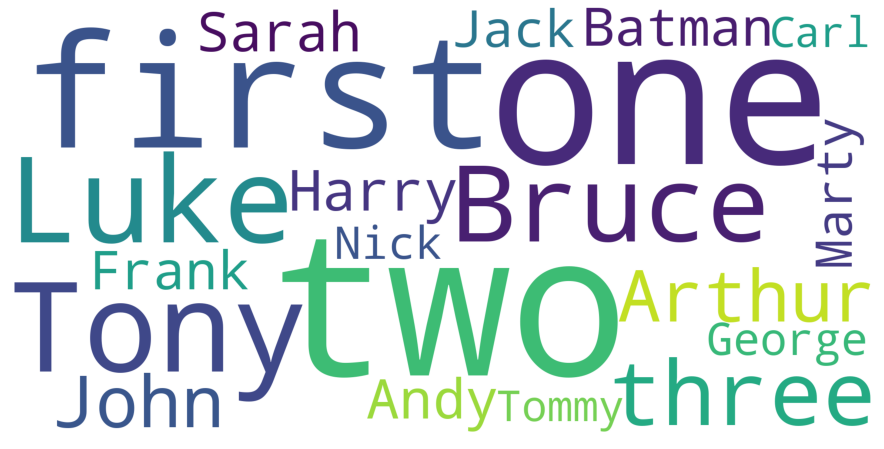

In [21]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_entities)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Fazit

Eine Analyse und Vorverarbeitung aller Dateneinträge hat uns gezeigt, dass es manche Dateneinträge gibt, die nicht für eine inhaltliche Analyse infrage kommen, da sie noch über keine Zusammenfassung verfügen. Diese haben wir demnach aus unserem Datensatz entfernt. Wir konnten ebenfalls feststellen, dass eine Reduzierung der BoWs die Varianz unserer Daten verringert. Im folgenden Kapitel beschäftigen wir uns mit einer Vektorisierung unserer Daten zur Clusteranalyse und Bestimmung von Ähnlichkeiten innerhalb der Cluster.

* [Weiter zu: Verarbeitung aller Dateneinträge](./4_nlp_analysis_schlaak_weise.ipynb)
* [Zurück zur Übersicht](./0_nlp_intro_schlaak_weise.ipynb)